<a href="https://colab.research.google.com/github/corvus-rex/object-detection/blob/master/PeopleCounting_POC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install protobuf, cython and tf-slim
!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install Cython
!pip install tf-slim

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
python-lxml is already the newest version (4.2.1-1ubuntu0.1).
python-pil is already the newest version (5.1.0-1ubuntu0.3).
python-tk is already the newest version (2.7.17-1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
# clone the master repo
!git clone https://github.com/tensorflow/models.git

In [ ]:
# compile proto files
# make sure you are in BASE_DIR/research/ (see cell below)
%cd /content/drive/My Drive/Laeveteinn/KopiOey/models/research/
!protoc object_detection/protos/*.proto --python_out=.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .

In [ ]:
# Add path environment
PERSONAL_DIR = "/content/drive/My Drive/Laeveteinn/KopiOey/"
BASE_DIR = PERSONAL_DIR + "models/"
%set_env PYTHONPATH=/content/drive/My Drive/Laeveteinn/KopiOey/models/research:/content/drive/My Drive/Laeveteinn/KopiOey/models/research/slim
import os
os.environ['PYTHONPATH'] += ":/content/drive/My Drive/Laeveteinn/KopiOey/models"
import sys
sys.path.insert(1, os.path.join(BASE_DIR, "official"))
print(sys.path)

# Run build test
!python object_detection/builders/model_builder_test.py

env: PYTHONPATH=/content/drive/My Drive/Laeveteinn/KopiOey/models/research:/content/drive/My Drive/Laeveteinn/KopiOey/models/research/slim
['', '/content/drive/My Drive/Laeveteinn/KopiOey/models/official', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython']
python3: can't open file 'object_detection/builders/model_builder_test.py': [Errno 2] No such file or directory


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import PIL

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
# Initialize variables
MODELS = ["centernet_resnet101_v1_fpn_512x512_coco17_tpu-8",
              "centernet_hg104_512x512_kpts_coco17_tpu-32",
              "centernet_hourglass104_512x512_kpts_coco17_tpu-32"]
MODEL_NAME = MODELS[0]
BASE_DOWNLOAD = "http://download.tensorflow.org/models/object_detection/tf2/20200711/"
DOWNLOAD_URL = BASE_DOWNLOAD + MODEL_NAME + ".tar.gz"
MODEL_FILE = MODEL_NAME + ".tar.gz"

In [ ]:
# Download and extract tar file
import six.moves.urllib as urllib
import tarfile

opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_URL, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
tar_file.extractall(os.getcwd())

In [ ]:
# Config and checkpoint dir
config_dir = BASE_DIR + "/research/object_detection/" + MODEL_NAME
pipeline_config = os.path.join(config_dir, "pipeline.config")
model_dir = BASE_DIR + "research/object_detection/" + MODEL_NAME + "/checkpoint"

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(model_dir, 'ckpt-0')).expect_partial()

print(pipeline_config)
def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

/content/drive/My Drive/Laeveteinn/KopiOey/models//research/object_detection/centernet_resnet101_v1_fpn_512x512_coco17_tpu-8/pipeline.config


In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = PIL.Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def load_frame_into_numpy_array(frame):
  image = PIL.Image.open(BytesIO(frame))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [ ]:
# Only detect people?
DETECT_HUMAN = True

In [ ]:
# Label map
if DETECT_HUMAN:
  label_map_path = BASE_DIR + "research/object_detection/data/mscoco_peopleonly_label_map.pbtxt"
else:
  label_map_path = BASE_DIR + "research/object_detection/data/mscoco_label_map.pbtxt"
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a differe

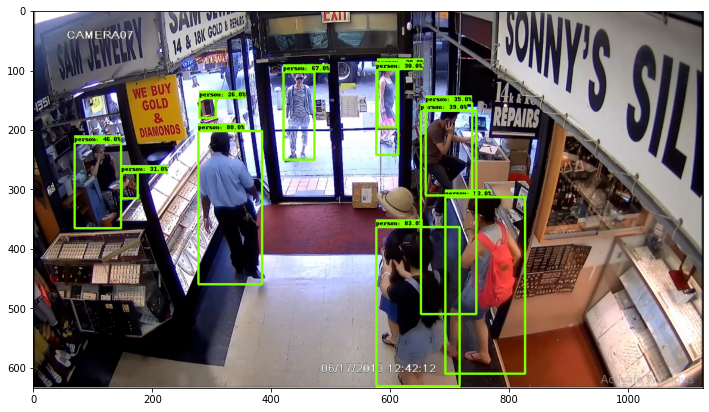

In [ ]:
# Testing model with still frame image

from IPython.display import clear_output, Image
import base64
import cv2

# Image Preparation
image_dir = PERSONAL_DIR + "evaluation_data/"
image_path = os.path.join(image_dir, 'stillframe0.jpg')
image_np = load_image_into_numpy_array(image_path)  # load image as np array

# Detection
input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1  # COCO dataset Class starts at index 1
image_np_with_detections = image_np.copy()  # for matplotlib display

if DETECT_HUMAN:
  selected_class = 1  # only selects one class from COCO dataset, 'Person'

# If Detect Human only is turned on, only display boxes, classes and scores
# that detects human in the image
if DETECT_HUMAN:
  # Indices where class == human
  indices = np.squeeze(np.argwhere((detections['detection_classes'][0] + label_id_offset) == selected_class))
  boxes = detections['detection_boxes'][0].numpy()
  boxes = boxes[[indices]]  # select corresponding array indices of the 4-point box
  classes = (detections['detection_classes'][0] + label_id_offset).numpy()
  classes = classes[[indices]]  # select corresponding array of the detected class
  scores = detections['detection_scores'][0].numpy()
  scores = scores[[indices]]  # select 
else:
  boxes = detections['detection_boxes'][0].numpy()
  classes = (detections['detection_classes'][0].numpy() + label_id_offset).astype(int)
  scores = detections['detection_scores'][0].numpy()

# Draw boxes and labels on the frame
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.25,  # minimum score for object to be considered as detected
      agnostic_mode=False)

# Matplotlib
plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()

In [ ]:
import cv2
import time

eval_dir = PERSONAL_DIR + "evaluation_data/"
video_path = eval_dir + "sample1.mp4"
out_dir = eval_dir + "out7.mp4"

cap = cv2.VideoCapture(video_path)
res=(928,576)  #resolution
fourcc = cv2.VideoWriter_fourcc('M','J','P','G') #codec
out = cv2.VideoWriter(out_dir, fourcc, 20.0, res)
label_id_offset = 1  # COCO dataset Class starts at index 1

if DETECT_HUMAN:
  selected_class = 1  # only selects one class from COCO dataset, 'Person'

duration = 40
start_time = time.time()
while (int(time.time() - start_time) <= duration):
  ret, frame_np = cap.read()

  if not ret:
    break

  # Detection
  input_tensor = tf.convert_to_tensor(np.expand_dims(frame_np, 0), dtype=tf.float32)
  detections, predictions_dict, shapes = detect_fn(input_tensor)

  frame_np_with_detections = frame_np.copy()  # for matplotlib display

  # If Detect Human only is turned on, only display boxes, classes and scores
  # that detects human in the image
  if DETECT_HUMAN:
    # Indices where class == human
    indices = np.squeeze(np.argwhere((detections['detection_classes'][0] + label_id_offset) == selected_class))
    boxes = detections['detection_boxes'][0].numpy()
    boxes = boxes[[indices]]  # select corresponding array indices of the 4-point box
    classes = (detections['detection_classes'][0] + label_id_offset).numpy()
    classes = classes[[indices]]  # select corresponding array of the detected class
    scores = detections['detection_scores'][0].numpy()
    scores = scores[[indices]]  # select 
  else:
    boxes = detections['detection_boxes'][0].numpy()
    classes = (detections['detection_classes'][0].numpy() + label_id_offset).astype(int)
    scores = detections['detection_scores'][0].numpy()

  # Draw boxes and labels on the frame
  viz_utils.visualize_boxes_and_labels_on_image_array(
        frame_np_with_detections,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.30,
        agnostic_mode=False)
  
  out.write(frame_np_with_detections)

cap.release()
out.release()